In [445]:
%matplotlib inline
import torch
from torch import nn
from torch import optim
import torch.distributions as dist
import torch.nn.functional as F
import torch.utils.data
from torchvision.utils import make_grid
from torchvision import datasets, transforms

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Bayes by backprop

Notebook based on Bayes by Backprop approach for training Bayesian Neural Network.

**Why Bayesian Neural Network**

Blablabla....

**My understanding of the article**

What I understand from the article:
- Let's denote $D$ our dataset and $\mathbf{w}$ the "parameters" of our model. As we are Bayesian, the parameters of our model are random variables and not real numbers.
- The ultimate goal of the optimisation process is to approximate the true posterior of our model $\mathbb{P}(\mathbf{w}\,|\,D)$. Indeed, this distribution can be used to give predictions about unseen queries:
$$\mathbb{P}\left(\mathbf{\hat y}\,|\,\mathbf{\hat x}, D\right) = \int \mathbb{P}\left(\mathbf{\hat y}\,|\,\mathbf{\hat x}, D, \mathbf{w}\right)d\mathbb{P}(\mathbf{w}\,|\,D) = \mathbb{E}_{\mathbb{P}(\mathbf{w}\,|\,D)}\left[\mathbb{P}\left(\mathbf{\hat y}\,|\,\mathbf{\hat x}, D, \mathbf{w}\right)\right]$$
- Thus we want to minimise the KL distance between the variational posterior and the true posterior. We can show this is equivalent to minimising the KL distance between the variational posterior and the prior plus the expected negative log-likelihood.

**Minimisation objective**

Add the equations.

**New advances since bayes by backprop**

To be documented.

**References:**
- Blundell C. et al. [Weight Uncertainty In Neural Networks](https://arxiv.org/pdf/1505.05424.pdf).
- Huge credit to @nitarshan for this [notebook](https://github.com/nitarshan/bayes-by-backprop/blob/master/Weight%20Uncertainty%20in%20Neural%20Networks.ipynb). A lot of code comes from this notebook with just a few modifications. 


## Organisation of the notebook

1. BayesianLinear 
    - *Bayesian linear layer as defined in the article.*
2. BayesianNetwork
    - *A simple Bayesian Network using multiple Bayesian Linear layers and a softmax to classify fmnist examples.*

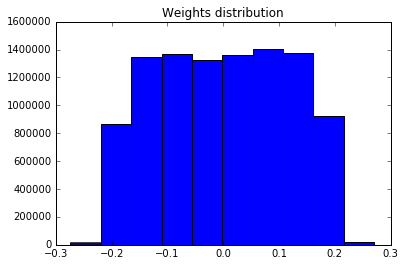

In [72]:
input_size, output_size = 100, 100
weight_distrib = torch.distributions.normal.Normal(torch.Tensor(output_size, input_size).uniform_(-0.2, 0.2), torch.Tensor(output_size, input_size).uniform_(0.005, 0.02))
plt.hist(weight_distrib.sample((1000,)).flatten())
plt.title("Weights distribution")
plt.show()

In [588]:
import math

# Prior initialisation
SIGMA = torch.FloatTensor([np.sqrt(0.5 * 0 + 0.5 * 6)])

# Variational Posterior initialisation
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

class Gaussian(nn.Module):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size())
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

class BayesianLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super(BayesianLinear, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(output_size, input_size).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(output_size, input_size).uniform_(-5, -4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(output_size).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(output_size).uniform_(-5, -4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        # Sampling and Log-probabilities are used when training.
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

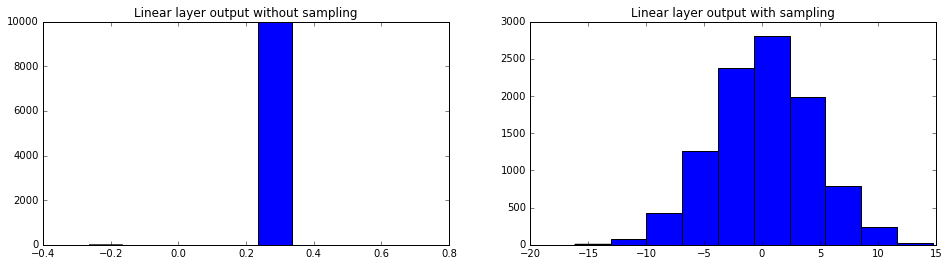

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].hist([layer(torch.ones(10), sample=False).detach().numpy()[0] for i in range(10000)])
axes[0].set_title("Linear layer output without sampling")

axes[1].hist([layer(torch.ones(10), sample=True).detach().numpy()[0] for i in range(10000)])
axes[1].set_title("Linear layer output with sampling")

plt.show()

In [315]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

In [628]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super(BayesianNetwork, self).__init__()
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)
    
    def forward(self, x, sample=False, calculate_log_probs=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample=sample)) # see how to make it simpler (args, kwargs)
        x = F.relu(self.l2(x, sample=sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l2.log_variational_posterior
    
    def sample_elbo(self, input, target, batch_id, samples=SAMPLES):
        r'''
        Compute ELBO (Evidence Lower Bound or also Variational Lower Bound).
        ELBO is the lower bound that we want to minimise in order to have a variational
        posterior as close as possible to the true posterior.
        
        Args:
            input: input tensor
            target: target prediction
            SAMPLES: number of samples used for each prediction

        Examples::
            
            >>> net = BayesianNetwork(10, 5)
            >>> net.train() # set the network in training mode
            >>> loss, _, _, _ = net.sample_elbo(data, target)
            >>> loss.backward()
            >>> optimizer.step()
        '''
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES)
        log_priors = torch.zeros(samples)
        log_variational_posteriors = torch.zeros(samples)
        
        # Sample predictions
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction="sum")
        #negative_log_likelihood = F.nll_loss(outputs.reshape(samples*BATCH_SIZE, CLASSES), target.repeat(samples), reduction='sum') / samples
        #batch_weight = 2**(NUM_BATCHES - (float(batch_id) + 1))/(2**NUM_BATCHES - 1)
        batch_weight = 1/NUM_BATCHES
        loss = (log_variational_posterior - log_prior) * batch_weight  + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

net = BayesianNetwork()

In [229]:
print(train_loader.dataset)
print("Batch size: {}".format(train_loader.batch_size))
print("Number of batches: {}".format(60000/train_loader.batch_size))

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./fmnist
    Transforms (if any): ToTensor()
    Target Transforms (if any): None
Batch size: 100
Number of batches: 600.0


In [629]:
net.train()
optimizer = optim.Adam(net.parameters())
#loss_hist = list()
TRAIN_EPOCHS = 5
for epoch in range(TRAIN_EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target, batch_idx)
        loss_hist.append(loss.item())
        print("\rEpoch id: {}\tBatch id: {}\tLoss: {}".format(epoch, batch_idx, loss_hist[-1]), end='')
        loss.backward()
        optimizer.step()

Epoch id: 4	Batch id: 599	Loss: 2431.307861328125

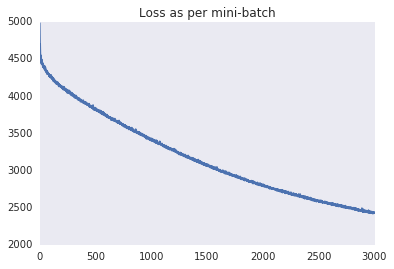

In [636]:
plt.plot(loss_hist[-TRAIN_EPOCHS*600:])
plt.title("Loss as per mini-batch")
plt.show()

tensor([9, 2, 1, 1, 6])


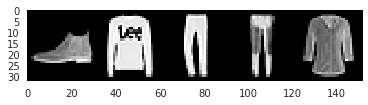

In [450]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
fmnist_sample = iter(test_loader).next()
fmnist_sample[0] = fmnist_sample[0]
print(fmnist_sample[1])
sns.set_style("dark")
show(make_grid(fmnist_sample[0]))

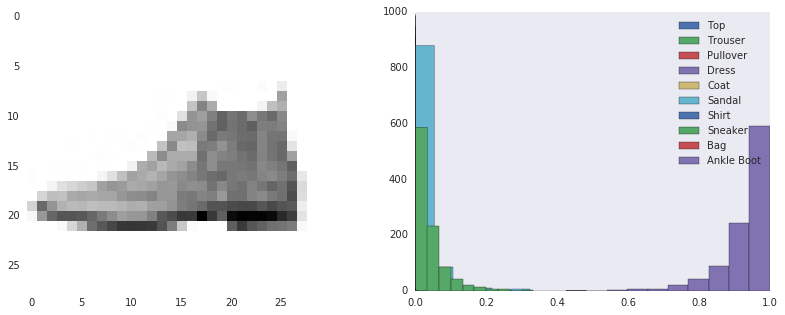

In [635]:
# Just ponderation
net.eval()
labels = ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
n_samples = 1000

# Sample predictions
res = np.ones((n_samples, 5, 10))
for sample in range(n_samples):
    res[sample,:,:] = net(fmnist_sample[0], True).detach().numpy()

# Plot predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(fmnist_sample[0].numpy()[0,0,:,:], interpolation='nearest')
for i in range(10):
    axes[1].hist(np.exp(res[:,0,i]), label=labels[i])
plt.legend()
plt.show()